In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [ ]:
fn='homesite.py'
with open(fn) as f:
    code=compile(f.read(),fn,'exec')
    exec(code)

loading training data ...
loading testing data ...
data loading completed...
sanitizing data ...
sanitizing data ...
get reduced set

In [145]:
colsT=dtrain.drop('QuoteConversion_Flag',axis=1).columns
colsE=dtest.drop('QuoteNumber',axis=1).columns
same=True
for x,y in zip(colsT,colsE):
    if x!=y:
        same=False
        print(x,y)
if same==True:
    print('all cols match')

all cols match


All columns are matching after we drop the first ones. So it is safe to run XGB and column order would not interfere. 


In [7]:
dtrain.columns

Index(['QuoteConversion_Flag', 'Field6', 'Field7', 'Field8', 'Field9',
       'Field10', 'Field11', 'Field12', 'CoverageField1A', 'CoverageField1B',
       ...
       'GeographicField61B', 'GeographicField62A', 'GeographicField62B',
       'GeographicField63', 'GeographicField64', 'Year', 'Month', 'Day',
       'DayOfWeek', 'LogSalesField8'],
      dtype='object', length=301)

In [9]:
lead='XXXX'
for col in colsT:
    if lead!=col[:4]:
        print(col)
        lead=col[:4]

Field6
CoverageField1A
SalesField1A
PersonalField1
PropertyField1A
GeographicField1A
Year
Month
Day
DayOfWeek
LogSalesField8


Let us divide and conquer. Create separate models based on the field types. Later let us merge these models. Otherwise, keeping it all together is very overwhelming. So lets have the cateogries as 
coveragemodel, salesmodel, personalmodel,propertymodel,geomodel,general (Field and other leftover fields).

In [146]:
covmodel=[]
salesmodel=[]
persmodel=[]
propmodel=[]
geomodel=[]
genmodel=[]
for col in colsT:
    lead=col[:4]
    if lead=='Cove':
        covmodel.append(col)
    elif lead=='Sale':
        salesmodel.append(col)
    elif lead=='Pers':
        persmodel.append(col)
    elif lead=='Prop':
        propmodel.append(col)
    elif lead=='Geog':
        geomodel.append(col)
    else:
        genmodel.append(col)
print(len(genmodel))

13


In [17]:
covmodel.append('QuoteConversion_Flag')
covtrainX=dtrain[covmodel]
covtrainX.corr()

,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField11A,CoverageField11B,QuoteConversion_Flag
CoverageField1A,1.000000,0.937883,0.988103,0.925601,0.926418,0.877162,0.963916,0.914018,0.098128,0.078360,0.058136,0.038344,-0.509591,-0.597754,-0.076398
CoverageField1B,0.937883,1.000000,0.928164,0.986216,0.877599,0.925904,0.906818,0.968154,0.102878,0.085789,0.055983,0.034113,-0.544354,-0.620499,-0.070245
CoverageField2A,0.988103,0.928164,1.000000,0.937342,0.935587,0.887479,0.954602,0.905365,0.099658,0.079145,0.057538,0.036361,-0.505093,-0.591476,-0.072644
CoverageField2B,0.925601,0.986216,0.937342,1.000000,0.885792,0.937065,0.896296,0.956830,0.104257,0.086243,0.055151,0.031585,-0.538181,-0.612317,-0.065846
CoverageField3A,0.926418,0.877599,0.935587,0.885792,1.000000,0.939408,0.888704,0.849568,0.182082,0.118447,0.032528,-0.041459,-0.453434,-0.519776,0.007271
CoverageField3B,0.877162,0.925904,0.887479,0.937065,0.939408,1.000000,0.841660,0.891725,0.183314,0.126423,0.029642,-0.043708,-0.482233,-0.537520,0.017365
CoverageField4A,0.963916,0.906818,0.954602,0.896296,0.888704,0.841660,1.000000,0.935780,0.084059,0.067331,0.066655,0.054346,-0.479820,-0.559701,-0.090893
CoverageField4B,0.914018,0.968154,0.905365,0.956830,0.849568,0.891725,0.935780,1.000000,0.090461,0.075029,0.064012,0.048797,-0.514716,-0.583206,-0.084327
CoverageField5A,0.098128,0.102878,0.099658,0.104257,0.182082,0.183314,0.084059,0.090461,1.000000,0.771845,0.468425,0.312627,-0.121549,-0.086039,0.088120
CoverageField5B,0.078360,0.085789,0.079145,0.086243,0.118447,0.126423,0.067331,0.075029,0.771845,1.000000,0.332982,0.334925,-0.179780,-0.124702,0.028350


Quoteconversion does not correlate strongly with any coverage fields. Is it due to class imabalance? Not sure. Lets look at other models and see if there is any model that weilds a stronger influence on conversion.

In [60]:
salesmodel.remove('QuoteConversion_Flag')
salesmodel.append('QuoteConversion_Flag')
smtrain=dtrain[salesmodel]
cr=smtrain.corr()
cr[cr['QuoteConversion_Flag']<-0.1]
cr[cr['QuoteConversion_Flag']>0.1]

,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,QuoteConversion_Flag
SalesField1A,1.000000,0.836175,0.769944,0.622721,-0.088574,0.086224,0.166029,-0.143959,0.011187,0.014547,-0.030216,-0.031762,0.064396,0.059178,0.056431,-0.217625
SalesField1B,0.836175,1.000000,0.616663,0.623710,-0.100585,0.110219,0.191348,-0.144107,0.018172,0.021303,-0.019553,-0.022454,0.055243,0.051624,0.049198,-0.253347
SalesField2A,0.769944,0.616663,1.000000,0.800855,-0.068205,0.044530,0.144767,-0.152852,0.006438,0.025626,-0.026913,-0.025566,0.072757,0.064952,0.062091,-0.175681
SalesField2B,0.622721,0.623710,0.800855,1.000000,-0.087135,0.059109,0.173705,-0.177592,0.011524,0.037603,-0.015612,-0.014834,0.054981,0.047088,0.044136,-0.184501
SalesField4,0.086224,0.110219,0.044530,0.059109,-0.077419,1.000000,0.763858,-0.170085,0.108527,0.030900,0.007376,0.008504,-0.025880,-0.033585,-0.033343,-0.217373
SalesField5,0.166029,0.191348,0.144767,0.173705,-0.128176,0.763858,1.000000,-0.346681,0.125425,0.072984,0.038359,0.040678,-0.013855,-0.024345,-0.024700,-0.350335


Though correlations are stronger than the Coverage set, the correlations are still weak. Lets keep exploring.

In [61]:
persmodel.remove('QuoteConversion_Flag')
persmodel.append('QuoteConversion_Flag')
pestrain=dtrain[persmodel]
cr=pestrain.corr()
cr[cr.iloc[78]>0.1]
cr[cr.iloc[78]<-0.1]


,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,...,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PersonalField84,QuoteConversion_Flag
PersonalField9,-0.029523,0.001577,-0.277825,-0.289160,0.044059,-0.048727,-0.003052,1.000000,-0.428816,-0.441604,...,-0.006092,-0.001971,-0.015278,-0.047852,-0.054312,-0.059410,-0.063722,-0.060928,-0.015807,-0.252054
PersonalField12,-0.069092,-0.047643,-0.276813,-0.288562,0.055481,-0.062318,-0.001465,0.587133,-0.696395,-0.836416,...,0.023140,0.028340,0.006450,-0.030676,-0.033915,-0.035786,-0.039553,-0.040359,0.017099,-0.170783
PersonalField13,-0.039294,0.022669,-0.005633,-0.004799,-0.008857,0.010260,0.001027,0.040490,0.000094,-0.005092,...,0.006745,0.007665,0.004423,-0.020772,-0.023396,-0.023737,-0.024669,-0.024546,0.003844,-0.177747


Only 8 feilds have correlation >0.1 and none >0.2

In [64]:
propmodel.remove('QuoteConversion_Flag')
propmodel.append('QuoteConversion_Flag')
print(len(propmodel))
protrain=dtrain[propmodel]
cr=protrain.corr()
cr[cr.iloc[-1]>0.1]
cr[cr.iloc[-1]<-0.1]

48


,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField6,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,...,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField27,PropertyField29,PropertyField35,PropertyField39A,PropertyField39B,QuoteConversion_Flag
PropertyField29,-0.122084,-0.122825,0.026246,-0.001376,NaN,-0.601831,0.003128,-0.015416,-0.077597,-0.192383,...,0.00812,0.218094,-0.068607,-0.087027,0.022058,1,-0.164338,-0.032831,-0.036528,-0.262605


In [66]:
geomodel.remove('QuoteConversion_Flag')
geomodel.append('QuoteConversion_Flag')
geotrain=dtrain[geomodel]
cr=geotrain.corr()
cr[cr.iloc[-1]>0.1]
cr[cr.iloc[-1]<-0.1]

,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,...,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,QuoteConversion_Flag
GeographicField6A,-0.195907,-0.177819,-0.321330,-0.313770,0.054531,0.050723,0.068733,0.069252,0.118723,0.235167,...,-0.067334,-0.114550,-0.123926,-0.038415,-0.031126,-0.050421,-0.216252,0.018962,0.043483,-0.177804
GeographicField6B,-0.230638,-0.222719,-0.258984,-0.248822,0.074401,0.071134,0.043282,0.043831,0.154191,0.454976,...,-0.080470,-0.070215,-0.073323,-0.016871,0.005387,-0.058033,-0.225682,0.012500,0.030428,-0.130080
GeographicField7A,-0.199356,-0.174892,-0.327640,-0.317434,0.058791,0.056719,0.065160,0.068385,0.217881,0.545648,...,-0.060065,-0.126651,-0.136232,-0.033759,-0.024485,-0.053501,-0.241212,0.009288,0.048815,-0.163546
GeographicField7B,-0.198035,-0.185349,-0.273264,-0.262527,0.059829,0.058454,0.028554,0.029957,0.168712,0.523192,...,-0.076131,-0.078802,-0.083315,-0.026275,-0.013466,-0.052416,-0.223491,-0.005382,0.019634,-0.137412
GeographicField8A,-0.199769,-0.180928,-0.320960,-0.312655,0.057813,0.054323,0.066539,0.067392,0.132200,0.287503,...,-0.069738,-0.113177,-0.122278,-0.038179,-0.028329,-0.051851,-0.223886,0.018851,0.044676,-0.175918
GeographicField8B,-0.221589,-0.211703,-0.257946,-0.248145,0.070201,0.068571,0.031828,0.032858,0.159385,0.474970,...,-0.080557,-0.069828,-0.073287,-0.025364,-0.003528,-0.054872,-0.227278,-0.004792,0.017776,-0.135599
GeographicField9A,-0.213612,-0.199880,-0.312826,-0.304180,0.048178,0.044961,0.050742,0.051359,0.179512,0.355402,...,-0.062396,-0.100836,-0.109242,-0.039210,-0.027035,-0.052133,-0.220594,0.018513,0.051461,-0.178197
GeographicField9B,-0.236594,-0.231105,-0.215042,-0.205224,0.089249,0.086272,0.028863,0.029199,0.160659,0.460881,...,-0.094990,-0.045034,-0.046438,-0.008147,0.018488,-0.061200,-0.221646,0.002681,0.016824,-0.134053
GeographicField11A,-0.189298,-0.167323,-0.331381,-0.323912,0.052932,0.049150,0.072252,0.073497,0.122870,0.258591,...,-0.064717,-0.124120,-0.135093,-0.041275,-0.033921,-0.048468,-0.219288,0.022555,0.053055,-0.181677
GeographicField11B,-0.228252,-0.214168,-0.259519,-0.248347,0.074678,0.072374,0.045982,0.046900,0.152151,0.449694,...,-0.075988,-0.068825,-0.071412,-0.026649,0.007411,-0.055422,-0.227572,0.015258,0.032693,-0.123649


In [68]:
genmodel.remove('QuoteConversion_Flag')
genmodel.append('QuoteConversion_Flag')
gentrain=dtrain[genmodel]
cr=gentrain.corr()
cr[cr.iloc[-1]>0.1]
cr[cr.iloc[-1]<-0.1]

,Field7,Field8,Field9,Field11,Year,Month,Day,DayOfWeek,LogSalesField8,QuoteConversion_Flag
Field7,1.00000,-0.436411,-0.572369,-0.25632,0.144845,0.108482,0.006624,0.007312,-0.000903,-0.137532
Field11,-0.25632,0.127229,0.144041,1.00000,0.170532,0.036767,-0.008103,0.007919,-0.001575,-0.100376


All correlations seem weak, except for a few. But none above 40%. 
We may take top correlations in each model and try against simply including all models.
Based on the split model probabilities, we can then average the predicted probabilities and then finally compute the AUC. Need to pause and think if this is a good idea at all.

/usr/local/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


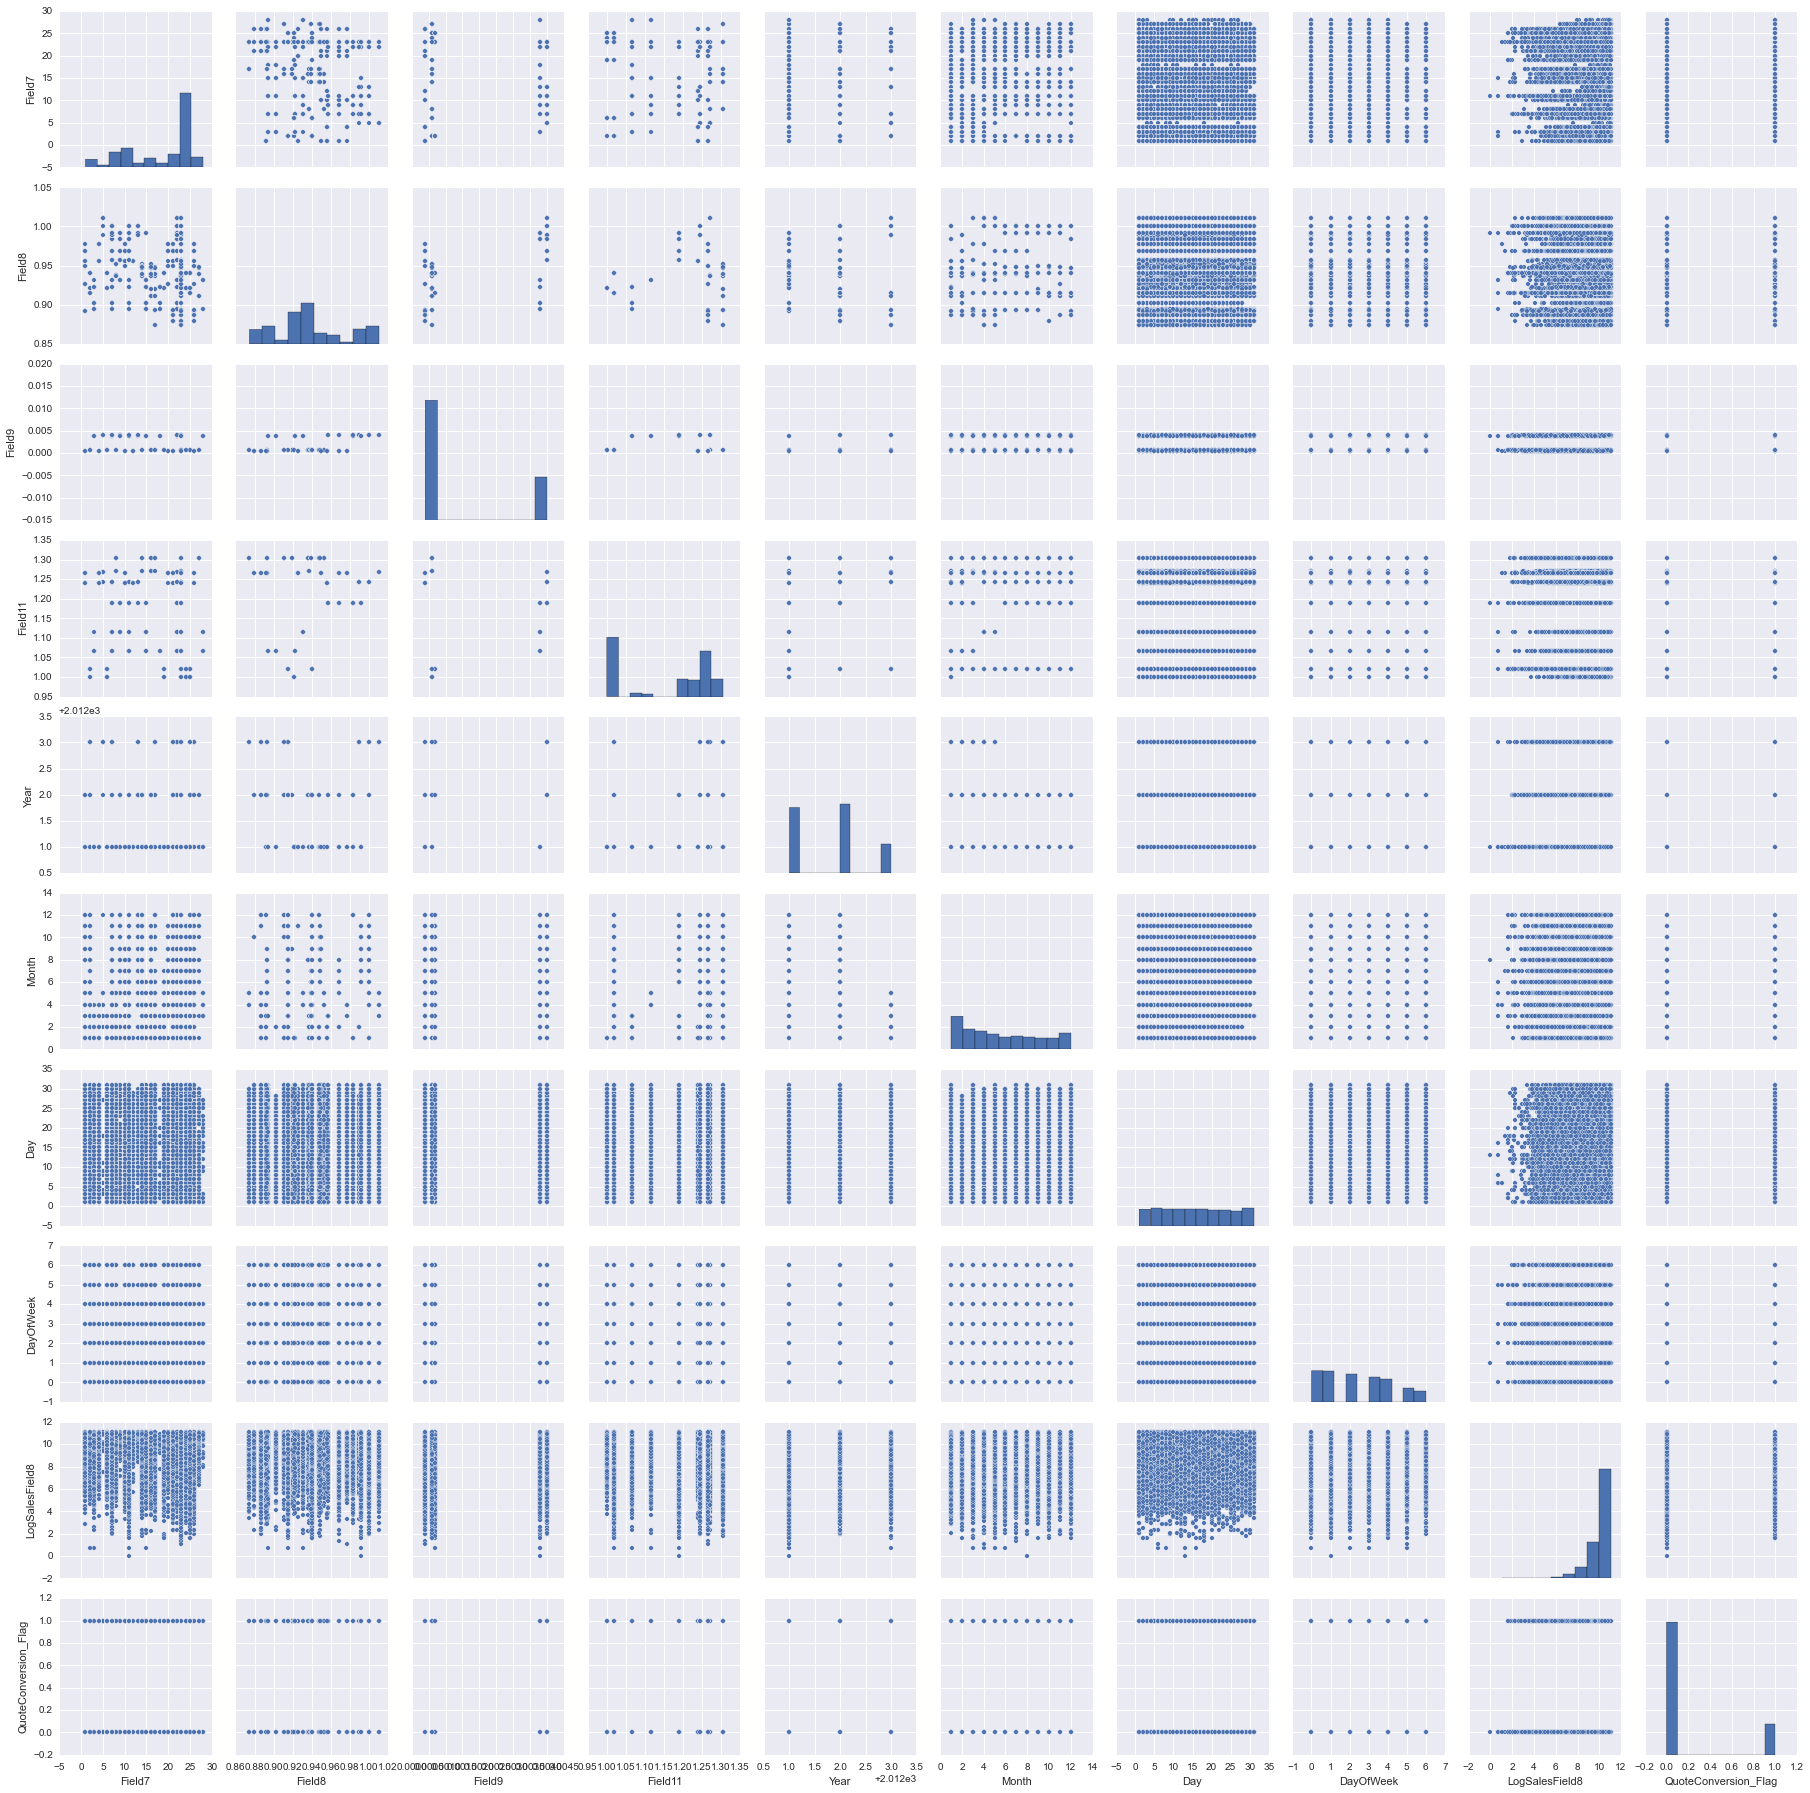

In [73]:
import seaborn as sns
sns.pairplot(gentrain)

In [5]:
dtest.columns

Index(['QuoteNumber', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10',
       'Field11', 'Field12', 'CoverageField1A', 'CoverageField1B',
       ...
       'GeographicField61B', 'GeographicField62A', 'GeographicField62B',
       'GeographicField63', 'GeographicField64', 'Year', 'Month', 'Day',
       'DayOfWeek', 'LogSalesField8'],
      dtype='object', length=301)

In [7]:
train.columns

Index(['Original_Quote_Date', 'QuoteConversion_Flag', 'Field6', 'Field7',
       'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'CoverageField1A',
       ...
       'GeographicField61B', 'GeographicField62A', 'GeographicField62B',
       'GeographicField63', 'GeographicField64', 'Year', 'Month', 'Day',
       'DayOfWeek', 'LogSalesField8'],
      dtype='object', length=303)

In [20]:
import seaborn as sns

/usr/local/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


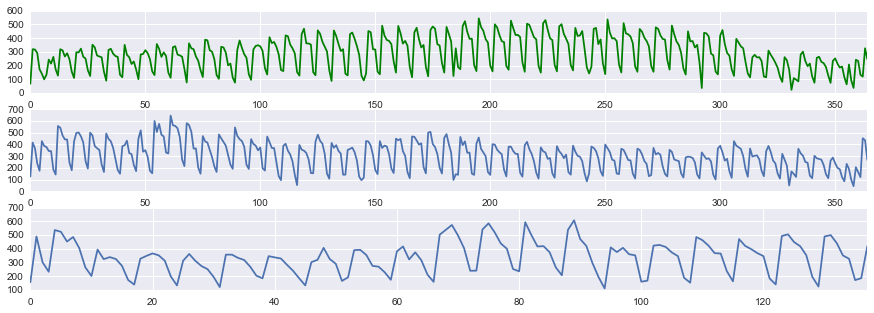

In [111]:
# Plot
fig, (axis1,axis2,axis3) = plt.subplots(3,figsize=(15,5),sharex=False,sharey=False)
sample=train[train['Year']==2013]
sgb=sample.groupby('Original_Quote_Date').count()
sns.tsplot(sgb['Field6'], color='green',ax=axis1)
sample=train[train['Year']==2014]
sgb=sample.groupby('Original_Quote_Date').count()
sns.tsplot(sgb['Field6'], ax=axis2)
sample=train[train['Year']==2015]
sgb=sample.groupby('Original_Quote_Date').count()
sns.tsplot(sgb['Field6'], ax=axis3)



/usr/local/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


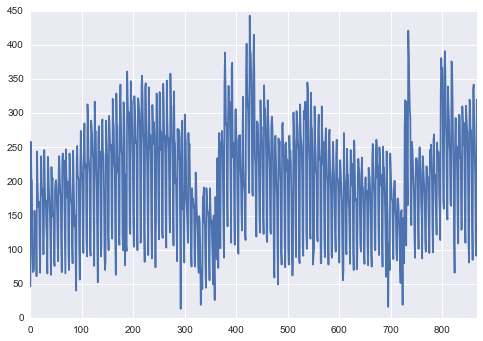

In [50]:
sample=test
sgb=sample.groupby('Original_Quote_Date').count()
sns.tsplot(sgb['Field6'])

Over time, both samples are looking identical. So we can choose a random sample and that should work well.

In [56]:
len(dtrain['GeographicField10A'].unique())

1

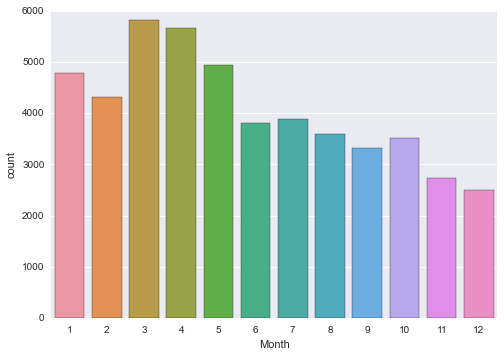

In [67]:
sns.countplot(x=train['Month'].loc[train['QuoteConversion_Flag']==1], order=[1,2,3,4,5,6,7,8,9,10,11,12])

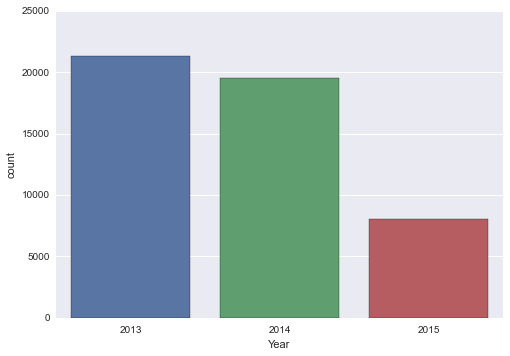

In [68]:
sns.countplot(x=train['Year'].loc[train['QuoteConversion_Flag']==1], order=[2013,2014,2015])

In [69]:
train['Original_Quote_Date'].describe()

count                  260753
unique                    868
top       2014-03-03 00:00:00
freq                      646
first     2013-01-01 00:00:00
last      2015-05-18 00:00:00
Name: Original_Quote_Date, dtype: object

In [70]:
test['Original_Quote_Date'].describe()

count                  173836
unique                    868
top       2014-03-03 00:00:00
freq                      443
first     2013-01-01 00:00:00
last      2015-05-18 00:00:00
Name: Original_Quote_Date, dtype: object

In [83]:
diff=True
trD=train['Original_Quote_Date'].unique()
teD=test['Original_Quote_Date'].unique()

for x,y in zip(sort(trD),sort(teD)):
    if x!=y:
        diff =False
print('it is ', diff, ' that the arrays are same')

it is  True  that the arrays are same


In [109]:
train[train['Year']==2014]['Original_Quote_Date'].unique().size

365

Train and Test data is spread evenly. Yearly trends are different between 2013 and 2014. But the summary stats are comparable. No outliers detected in the target pattern. Now the next step is feature engineering.

Let us try and remove columns that have just one value.

In [147]:
cols=train.apply(lambda col: len(col.unique()))
dropcols=[cols.index[i] for i, col in enumerate(cols) if col==1]

In [148]:
dropcols
    

['PropertyField6', 'GeographicField10A']

In [149]:
a,b,c,d,e,f=splitCategories(dtrain.columns)

In [157]:
f

['Field6',
 'Field7',
 'Field8',
 'Field9',
 'Field10',
 'Field11',
 'Field12',
 'Year',
 'Month',
 'Day',
 'DayOfWeek',
 'DayOfYear',
 'LogSalesField8']

In [151]:
b

['SalesField1A',
 'SalesField1B',
 'SalesField2A',
 'SalesField2B',
 'SalesField3',
 'SalesField4',
 'SalesField5',
 'SalesField6',
 'SalesField7',
 'SalesField9',
 'SalesField10',
 'SalesField11',
 'SalesField12',
 'SalesField13',
 'SalesField14',
 'SalesField15']

In [161]:
x=salesmodel
x.append('QuoteConversion_Flag')

In [2]:
import seaborn as sns
sns.pairplot(dtrain[x])

NameError: name 'dtrain' is not defined